test: classification using either regular bert or fine-tuned bert


https://www.kaggle.com/datasets/arbazkhan971/analyticvidhyadatasetsentiment

https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [3]:
import numpy as np
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
epochs = 5
lr = 1e-6
batch_size = 8
checkpoint = "seiya/oubiobert-base-uncased"

# Define dataset

In [5]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') #tokenizer is the same for both models

class MakeDataset(torch.utils.data.Dataset):

    def __init__(self, df, text_feature, target):

        self.labels = [label for label in df[target]]
        
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df[text_feature]]
        
        
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [6]:
df = pd.read_csv("/kaggle/input/analyticvidhyadatasetsentiment/train_F3WbcTw.csv")

text_feature = 'text'
target = 'sentiment'

df_train, df_test = train_test_split(df, train_size=4800, test_size=len(df)-4800)

dataset_train = MakeDataset(df_train, text_feature, target)
dataset_test = MakeDataset(df_test, text_feature, target)

# Train and test functions

In [7]:
def train(model, learning_rate, epochs, batch_size):

    train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    #val_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    #criterion = torch.nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            #criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask, labels=train_label)
                
                batch_loss = output.loss
                total_loss_train += batch_loss.item()
                
                acc = (output.logits.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            #with torch.no_grad():

            #    for val_input, val_label in val_dataloader:

            #        val_label = val_label.to(device)
            #        mask = val_input['attention_mask'].to(device)
            #        input_id = val_input['input_ids'].squeeze(1).to(device)

             #       output = model(input_id, mask)

             #       batch_loss = output.loss
             #       total_loss_val += batch_loss.item()
                    
             #       acc = (output.logits.argmax(dim=1) == val_label).sum().item()
             #       total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(dataset_train): .3f} \
                | Train Accuracy: {total_acc_train / len(dataset_train): .3f} ')#\
                #| Val Loss: {total_loss_val / len(dataset_val): .3f} \
                #| Val Accuracy: {total_acc_val / len(dataset_val): .3f}')

In [17]:
def evaluate(model, batch_size):

    test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    y_true = []
    y_pred = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            pred = output.logits.argmax(dim=1)
            acc = (pred == test_label).sum().item()
            total_acc_test += acc
            
            y_pred.extend(pred.cpu().numpy())
            y_true.extend(test_label.cpu().numpy())
    
    #print(y_true, y_pred)
    conf_mat = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[0,1,2])
    disp.plot()
    print(f'Test Accuracy: {total_acc_test / len(dataset_test): .3f}')

 # Bert base

In [ ]:
#checkpoint = "bert-base-uncased"
#model_base = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)

In [ ]:
#train(model_base, lr, epochs, batch_size)

In [ ]:
#evaluate(model_base, batch_size)

# bert finetuned

In [9]:
checkpoint = "seiya/oubiobert-base-uncased"
#checkpoint = "emilyalsentzer/Bio_ClinicalBERT"
model_finetuned = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at seiya/oubiobert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

In [10]:
train(model_finetuned, lr, epochs, batch_size)

100%|██████████| 600/600 [04:14<00:00,  2.35it/s]


Epochs: 1 | Train Loss:  0.099                 | Train Accuracy:  0.724 


100%|██████████| 600/600 [04:13<00:00,  2.37it/s]


Epochs: 2 | Train Loss:  0.096                 | Train Accuracy:  0.724 


100%|██████████| 600/600 [04:13<00:00,  2.37it/s]


Epochs: 3 | Train Loss:  0.094                 | Train Accuracy:  0.724 


100%|██████████| 600/600 [04:13<00:00,  2.37it/s]


Epochs: 4 | Train Loss:  0.090                 | Train Accuracy:  0.724 


100%|██████████| 600/600 [04:13<00:00,  2.37it/s]

Epochs: 5 | Train Loss:  0.084                 | Train Accuracy:  0.734 


Test Accuracy:  0.727


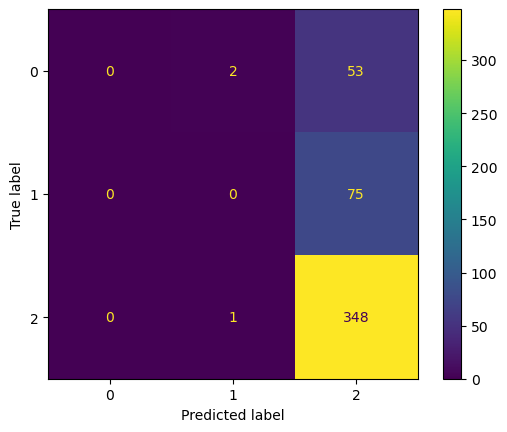

In [18]:
evaluate(model_finetuned, batch_size)

In [ ]:
#TODO: save checkpoints
#Run more epochs?

NameError: name 'test_dataloader' is not defined

In [12]:
print(f'Test Accuracy: {total_acc_test / len(dataset_test): .3f}')

NameError: name 'total_acc_test' is not defined